In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#https://github.com/vlawhern/arl-eegmodels
"""
 ARL_EEGModels - A collection of Convolutional Neural Network models for EEG
 Signal Processing and Classification, using Keras and Tensorflow

 Requirements:
    (1) tensorflow == 2.X (as of this writing, 2.0 - 2.3 have been verified
        as working)
 
 To run the EEG/MEG ERP classification sample script, you will also need

    (4) mne >= 0.17.1
    (5) PyRiemann >= 0.2.5
    (6) scikit-learn >= 0.20.1
    (7) matplotlib >= 2.2.3
    
 To use:
    
    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)
    (2) Import the model as
        
        from EEGModels import EEGNet    
        
        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)
        
    (3) Then compile and fit the model
    
        model.compile(loss = ..., optimizer = ..., metrics = ...)
        fitted    = model.fit(...)
        predicted = model.predict(...)

 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those 
 portions are released world-wide under the terms of the Creative Commons Zero 
 1.0 (CC0) license.  
 
 Other portions of this project are subject to domestic copyright protection 
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0 
 license.  The complete text of the license governing this material is in 
 the file labeled LICENSE.TXT that is a part of this project's official 
 distribution. 
"""

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)




def EEGNet_SSVEP(nb_classes = 12, Chans = 8, Samples = 256, 
             dropoutRate = 0.5, kernLength = 256, F1 = 96, 
             D = 1, F2 = 96, dropoutType = 'Dropout'):
    """ SSVEP Variant of EEGNet, as used in [1]. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. 
      D               : number of spatial filters to learn within each temporal
                        convolution.
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
      
      
    [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
    for Classification of Asynchronous Steady-State Visual Evoked Potentials.
    Journal of Neural Engineering vol. 15(6). 
    http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)



def EEGNet_old(nb_classes, Chans = 64, Samples = 128, regRate = 0.0001,
           dropoutRate = 0.25, kernels = [(2, 32), (8, 4)], strides = (2, 4)):
    """ Keras Implementation of EEGNet_v1 (https://arxiv.org/abs/1611.08024v2)

    This model is the original EEGNet model proposed on arxiv
            https://arxiv.org/abs/1611.08024v2
    
    with a few modifications: we use striding instead of max-pooling as this 
    helped slightly in classification performance while also providing a 
    computational speed-up. 
    
    Note that we no longer recommend the use of this architecture, as the new
    version of EEGNet performs much better overall and has nicer properties.
    
    Inputs:
        
        nb_classes     : total number of final categories
        Chans, Samples : number of EEG channels and samples, respectively
        regRate        : regularization rate for L1 and L2 regularizations
        dropoutRate    : dropout fraction
        kernels        : the 2nd and 3rd layer kernel dimensions (default is 
                         the [2, 32] x [8, 4] configuration)
        strides        : the stride size (note that this replaces the max-pool
                         used in the original paper)
    
    """

    # start the model
    input_main   = Input((Chans, Samples))
    layer1       = Conv2D(16, (Chans, 1), input_shape=(Chans, Samples, 1),
                                 kernel_regularizer = l1_l2(l1=regRate, l2=regRate))(input_main)
    layer1       = BatchNormalization()(layer1)
    layer1       = Activation('elu')(layer1)
    layer1       = Dropout(dropoutRate)(layer1)
    
    permute_dims = 2, 1, 3
    permute1     = Permute(permute_dims)(layer1)
    
    layer2       = Conv2D(4, kernels[0], padding = 'same', 
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(permute1)
    layer2       = BatchNormalization()(layer2)
    layer2       = Activation('elu')(layer2)
    layer2       = Dropout(dropoutRate)(layer2)
    
    layer3       = Conv2D(4, kernels[1], padding = 'same',
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(layer2)
    layer3       = BatchNormalization()(layer3)
    layer3       = Activation('elu')(layer3)
    layer3       = Dropout(dropoutRate)(layer3)
    
    flatten      = Flatten(name = 'flatten')(layer3)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)



def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)



Epoch 1/20
3/3 - 1s - loss: 0.7144 - accuracy: 0.4103 - val_loss: 0.6875 - val_accuracy: 0.5556 - 892ms/epoch - 297ms/step
Epoch 2/20
3/3 - 0s - loss: 0.6698 - accuracy: 0.6923 - val_loss: 0.6908 - val_accuracy: 0.5556 - 62ms/epoch - 21ms/step
Epoch 3/20
3/3 - 0s - loss: 0.6403 - accuracy: 0.7179 - val_loss: 0.6915 - val_accuracy: 0.5185 - 54ms/epoch - 18ms/step
Epoch 4/20
3/3 - 0s - loss: 0.6358 - accuracy: 0.6154 - val_loss: 0.6922 - val_accuracy: 0.5185 - 54ms/epoch - 18ms/step
Epoch 5/20
3/3 - 0s - loss: 0.5978 - accuracy: 0.6667 - val_loss: 0.6919 - val_accuracy: 0.5556 - 74ms/epoch - 25ms/step
Epoch 6/20
3/3 - 0s - loss: 0.6023 - accuracy: 0.6154 - val_loss: 0.6920 - val_accuracy: 0.5185 - 59ms/epoch - 20ms/step
Epoch 7/20
3/3 - 0s - loss: 0.5937 - accuracy: 0.6667 - val_loss: 0.6917 - val_accuracy: 0.5185 - 55ms/epoch - 18ms/step
Epoch 8/20
3/3 - 0s - loss: 0.5803 - accuracy: 0.6923 - val_loss: 0.6917 - val_accuracy: 0.4815 - 64ms/epoch - 21ms/step
Epoch 9/20
3/3 - 0s - loss: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:213: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3/3 - 0s - loss: 0.6758 - accuracy: 0.6250 - val_loss: 0.6915 - val_accuracy: 0.5556 - 65ms/epoch - 22ms/step
Epoch 5/20
3/3 - 0s - loss: 0.6473 - accuracy: 0.6750 - val_loss: 0.6917 - val_accuracy: 0.4815 - 70ms/epoch - 23ms/step
Epoch 6/20
3/3 - 0s - loss: 0.6310 - accuracy: 0.7500 - val_loss: 0.6915 - val_accuracy: 0.4815 - 65ms/epoch - 22ms/step
Epoch 7/20
3/3 - 0s - loss: 0.6402 - accuracy: 0.7500 - val_loss: 0.6914 - val_accuracy: 0.4815 - 65ms/epoch - 22ms/step
Epoch 8/20
3/3 - 0s - loss: 0.6108 - accuracy: 0.7500 - val_loss: 0.6911 - val_accuracy: 0.4444 - 62ms/epoch - 21ms/step
Epoch 9/20
3/3 - 0s - loss: 0.6038 - accuracy: 0.7750 - val_loss: 0.6911 - val_accuracy: 0.4444 - 56ms/epoch - 19ms/step
Epoch 10/20
3/3 - 0s - loss: 0.5974 - accuracy: 0.8000 - val_loss: 0.6909 - val_accuracy: 0.4444 - 60ms/epoch - 20ms/step
Epoch 11/20
3/3 - 0s - loss: 0.5491 - accuracy: 0.8250 - val_loss: 0.6909 - val_accuracy: 0.4444 - 60ms/epoch - 20ms/step
Epoch

[[0.4953357100415924],
 [0.36919191919191924],
 [0.4856209150326797],
 [0.29512774806892456],
 [0.3108140225787285],
 [0.39298871063576946],
 [0.3228163992869876],
 [0.4091206179441474],
 [0.4667855020796197],
 [0.4164289958407606],
 [0.2937314319667261],
 [0.4035353535353535],
 [0.24221628045157453],
 [0.44177064765300056],
 [0.5603386809269163],
 [0.4430184194890077],
 [0.24949494949494952],
 [0.30576351752822345],
 [0.28728461081402257],
 [0.5472667855020796],
 [0.33220439691027925],
 [0.3694295900178253],
 [0.5067439096850862],
 [0.2599524658348188],
 [0.1913250148544266],
 [0.42712418300653593],
 [0.6076648841354724]]

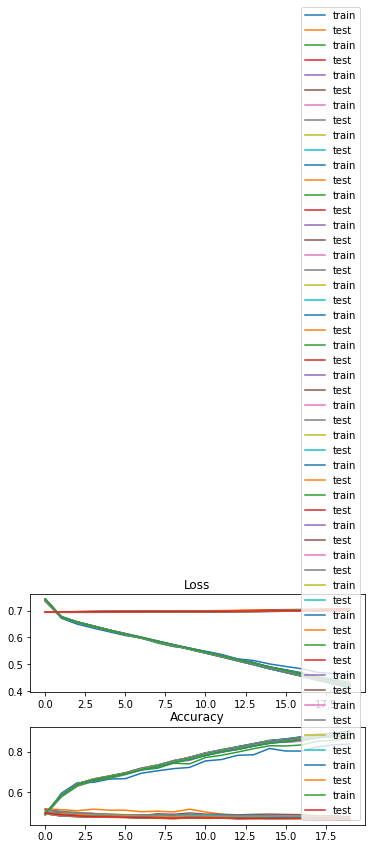

In [ ]:
#mo->mo, me->me, mi->mi 정확도 추출 시 사용 
from scipy.io import loadmat
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
#https://stackoverflow.com/questions/473973/shuffle-an-array-with-python-randomize-array-item-order-with-python

lst = ['S001','S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 
       'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 
       'S021', 'S022', 'S023', 'S024',  'S026', 'S027', 'S028']


c = 1           #fig save할 때 sub_num으로 사용하기 위한 변수 
sub_total = [] #한 피험자의 최종 평균 정확도 담는 배열 (피험자 순서대로 저장됨)
tmp = []

#피험자 별 loss, val_loss, acc, val_acc 값을 담기위한 list
loss_total = []
val_loss_total = []
acc_total = []
val_acc_total = []

#피험자 수만큼 돌아가는 반복문 
for i in range(len(lst)):       
  me_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_me_l.mat')
  me_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_me_r.mat')
  mo_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mo_l.mat')
  mo_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mo_r.mat')
  mi_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mi_l.mat')
  mi_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mi_r.mat')

  me_l_tmp = me_l['epoched_me_l']
  me_r_tmp = me_r['epoched_me_r']
  mo_l_tmp = mo_l['epoched_mo_l']
  mo_r_tmp = mo_r['epoched_mo_r']
  mi_l_tmp = mi_l['epoched_mi_l']
  mi_r_tmp = mi_r['epoched_mi_r']

  me = np.concatenate([me_l_tmp, me_r_tmp], axis = 2)
  mo = np.concatenate([mo_l_tmp, mo_r_tmp], axis = 2)
  mi = np.concatenate([mi_l_tmp, mi_r_tmp], axis = 2)

  #-1, 0, 1, 2, 3 (총 4s 데이터)
  kernels, chans, samples = 1, 19, 1200

  me = torch.from_numpy(me)
  mi = torch.from_numpy(mi)
  mo = torch.from_numpy(mo)

  #(900, 19, 100) -> (100, 19, 900)
  me = me.permute(2, 1, 0)
  mi = mi.permute(2, 1, 0)
  mo = mo.permute(2, 1, 0)

  me = me.numpy()
  mi = mi.numpy()
  mo = mo.numpy()

  y = np.array([0] * 50 + [1] * 50)

  total_acc = []

  total_acc_me = []
  total_acc_mo = []
  total_acc_mi = []
  
  #10 - 3 fold 에서 10을 담당하는 반복문 
  #해당 코드는 5 fold로 train, test 데이터를 구분한 후, 10번 데이터를 셔플하는 순서로 진행됨 
  for j in range(10):
    me_X, me_y = shuffle(me, y, random_state = 0)
    mo_X, mo_y = shuffle(mo, y, random_state = 0)
    mi_X, mi_y = shuffle(mi, y, random_state = 0)
    
    # train : valid = 7:3 , test는 전체 데이터를 다 사용함 
    # ex) me->mi 예측 모델의 경우, me 100개를 7:3으로 train, valid 나누고 mi 전체를 test로 사용
    kfold = KFold(n_splits = 3) #7:3

    acc_result = []
    acc_result_me = []
    acc_result_mo = []
    acc_result_mi = []

    i += 1
    for train_idx, test_idx in kfold.split(me_X, me_y):

      me_X_train_tmp, me_X_test = me_X[train_idx], me_X[test_idx]
      me_y_train_tmp, me_y_test = me_y[train_idx], me_y[test_idx]
      me_X_train, me_X_valid, me_y_train, me_y_valid = train_test_split(me_X_train_tmp, me_y_train_tmp, test_size=0.4, shuffle=False)

      mo_X_train_tmp, mo_X_test = mo_X[train_idx], mo_X[test_idx]
      mo_y_train_tmp, mo_y_test = mo_y[train_idx], mo_y[test_idx]
      mo_X_train, mo_X_valid, mo_y_train, mo_y_valid = train_test_split(mo_X_train_tmp, mo_y_train_tmp, test_size=0.4, shuffle=False)

      mi_X_train_tmp, mi_X_test = mi_X[train_idx], mi_X[test_idx]
      mi_y_train_tmp, mi_y_test = mi_y[train_idx], mi_y[test_idx]
      mi_X_train, mi_X_valid, mi_y_train, mi_y_valid = train_test_split(mi_X_train_tmp, mi_y_train_tmp, test_size=0.4, shuffle=False)


      #각 값들 바꿔주면서 정확도 뽑으면 됨. 
      train_x = mi_X_train
      train_y = mi_y_train
      val_x = mi_X_valid
      val_y = mi_y_valid
      test_x = mi_X_test
      test_y = mi_y_test
      
      
      train_x = train_x.reshape(train_x.shape[0], chans, samples, kernels)
      val_x = val_x.reshape(val_x.shape[0], chans, samples, kernels)
      test_x = test_x.reshape(test_x.shape[0], chans, samples, kernels)

      
      with tf.device('/device:GPU:0'):
        model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
                dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')
        
        #loss func(sparse_categorical_crossentropy) 선택 이유 
        #https://ahnjg.tistory.com/88
        #https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics = ['accuracy'])

        fittedModel = model.fit(train_x, train_y, batch_size = 16, epochs = 20, 
                            verbose = 2,
                             validation_data=(val_x, val_y))
        # fittedModel_mo = model.fit(mo_X_train, mo_y_train, batch_size = 16, epochs = 10, 
        #                     verbose = 2, validation_data=(mo_X_valid, mo_y_valid))
        # fittedModel_mi = model.fit(mi_X_train, mi_y_train, batch_size = 16, epochs = 10, 
        #                     verbose = 2, validation_data=(mi_X_valid, mi_y_valid))
        
        loss_total.append(fittedModel.history['loss'])
        val_loss_total.append(fittedModel.history['val_loss'])
        acc_total.append(fittedModel.history['accuracy'])
        val_acc_total.append(fittedModel.history['val_accuracy'])

        probs       = model.predict(test_x)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == test_y.argmax(axis=-1))

        # probs_mo       = model.predict(mo_X_test)
        # preds_mo       = probs_mo.argmax(axis = -1)  
        # acc_mo         = np.mean(preds_mo == mo_y_test.argmax(axis=-1))

        # probs_mi       = model.predict(mi_X_test)
        # preds_mi       = probs_mi.argmax(axis = -1)  
        # acc_mi         = np.mean(preds_mi == mi_y_test.argmax(axis=-1))

      acc_result.append(acc)
      # acc_result_mo.append(acc_mo)
      # acc_result_mi.append(acc_mi)

    
    total_acc.append(np.mean(acc_result))
    # total_acc_mo.append(np.mean(acc_result_mo))
    # total_acc_mi.append(np.mean(acc_result_mi))
    
  tmp = [np.mean(total_acc)]
  sub_total.append(tmp) #한 피험자의 최종 정확도 저장 
  print("total acc =", tmp )

  #한 피험자 당 loss, acc 평균 내기 위한 부분
  m_loss = []
  m_val_loss = []
  m_acc = []
  m_val_acc = []
  s_loss = []
  s_val_loss = []
  s_acc = []
  s_val_acc = []
  for k in range(len(loss_total[0])): #epoch 갯수만큼 (현재는 epoch = 20)
    t1 = []
    t2 = []
    t3 = []
    t4 = []
    for j in range(len(loss_total)):
      t1.append(loss_total[j][k])
      t2.append(val_loss_total[j][k])
      t3.append(acc_total[j][k])
      t4.append(val_acc_total[j][k])
    m_loss.append(np.mean(t1))
    m_val_loss.append(np.mean(t2))
    m_acc.append(np.mean(t3))
    m_val_acc.append(np.mean(t4))
    
    s_loss.append(np.std(t1))
    s_val_loss.append(np.std(t2))
    s_acc.append(np.std(t3))
    s_val_acc.append(np.std(t4))
    
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.plot(m_loss, label='train')
  pyplot.plot(m_val_loss, label='test')

  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.plot(m_acc, label='train')
  pyplot.plot(m_val_acc, label='test')

  pyplot.legend()
  pyplot.subplots_adjust(left=0.125,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.2, 
                      hspace=0.35)
  
  # pyplot.savefig('%s.png'%c)
  c = c+1
  

sub_total #결과 정확도 출력

In [ ]:
#me->mi, me -> mo, mi->me, mi -> mo, mo->mi, mo -> me 정확도 추출 시 사용
from scipy.io import loadmat
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
#https://stackoverflow.com/questions/473973/shuffle-an-array-with-python-randomize-array-item-order-with-python

lst = ['S001','S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010',
        'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 
       'S021', 'S022', 'S023', 'S024',  'S026', 'S027', 'S028']

c = 1           #fig save할 때 sub_num으로 사용하기 위한 변수 
sub_total = [] #한 피험자의 최종 평균 정확도 담는 배열 (피험자 순서대로 저장됨)
tmp = []

#피험자 별 loss, val_loss, acc, val_acc 값을 담기위한 list
loss_total = []
val_loss_total = []
acc_total = []
val_acc_total = []

#피험자 수만큼 돌아가는 반복문 
for i in range(len(lst)):       
  me_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_me_l.mat')
  me_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_me_r.mat')
  mo_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mo_l.mat')
  mo_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mo_r.mat')
  mi_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mi_l.mat')
  mi_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mi_r.mat')

  me_l_tmp = me_l['epoched_me_l']
  me_r_tmp = me_r['epoched_me_r']
  mo_l_tmp = mo_l['epoched_mo_l']
  mo_r_tmp = mo_r['epoched_mo_r']
  mi_l_tmp = mi_l['epoched_mi_l']
  mi_r_tmp = mi_r['epoched_mi_r']

  me = np.concatenate([me_l_tmp, me_r_tmp], axis = 2)
  mo = np.concatenate([mo_l_tmp, mo_r_tmp], axis = 2)
  mi = np.concatenate([mi_l_tmp, mi_r_tmp], axis = 2)

  #-1, 0, 1, 2, 3 (총 4s 데이터)
  kernels, chans, samples = 1, 19, 1200

  me = torch.from_numpy(me)
  mi = torch.from_numpy(mi)
  mo = torch.from_numpy(mo)

  #(900, 19, 100) -> (100, 19, 900)
  me = me.permute(2, 1, 0)
  mi = mi.permute(2, 1, 0)
  mo = mo.permute(2, 1, 0)

  me = me.numpy()
  mi = mi.numpy()
  mo = mo.numpy()

  y = np.array([0] * 50 + [1] * 50)

  total_acc = []

  total_acc_me = []
  total_acc_mo = []
  total_acc_mi = []
  
  #10 - 3 fold 에서 10을 담당하는 반복문 
  #해당 코드는 5 fold로 train, test 데이터를 구분한 후, 10번 데이터를 셔플하는 순서로 진행됨 
  for j in range(10):
    me_X, me_y = shuffle(me, y, random_state = 0)
    mo_X, mo_y = shuffle(mo, y, random_state = 0)
    mi_X, mi_y = shuffle(mi, y, random_state = 0)
    
    # train : valid = 7:3 , test는 전체 데이터를 다 사용함 
    # ex) me->mi 예측 모델의 경우, me 100개를 7:3으로 train, valid 나누고 mi 전체를 test로 사용
    kfold = KFold(n_splits = 3) #7:3

    acc_result = []
    acc_result_me = []
    acc_result_mo = []
    acc_result_mi = []

    i += 1
    for train_idx, test_idx in kfold.split(me_X, me_y):

      me_X_train, me_X_valid = me_X[train_idx], me_X[test_idx]
      me_y_train, me_y_valid = me_y[train_idx], me_y[test_idx]
      
      mo_X_train, mo_X_valid = mo_X[train_idx], mo_X[test_idx]
      mo_y_train, mo_y_valid = mo_y[train_idx], mo_y[test_idx]

      mi_X_train, mi_X_valid = mi_X[train_idx], mi_X[test_idx]
      mi_y_train_tmp, mi_y_valid = mi_y[train_idx], mi_y[test_idx]

      #각 값들 바꿔주면서 정확도 뽑으면 됨. 
      train_x = mo_X_train
      train_y = mo_y_train
      val_x = mo_X_valid
      val_y = mo_y_valid
      test_x = mi_X
      test_y = mi_y
      
      
      train_x = train_x.reshape(train_x.shape[0], chans, samples, kernels)
      val_x = val_x.reshape(val_x.shape[0], chans, samples, kernels)
      test_x = test_x.reshape(test_x.shape[0], chans, samples, kernels)

      
      with tf.device('/device:GPU:0'):
        model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
                dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')
        
        #loss func(sparse_categorical_crossentropy) 선택 이유 
        #https://ahnjg.tistory.com/88
        #https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics = ['accuracy'])

        fittedModel = model.fit(train_x, train_y, batch_size = 16, epochs = 20, 
                            verbose = 2,
                             validation_data=(val_x, val_y))
        # fittedModel_mo = model.fit(mo_X_train, mo_y_train, batch_size = 16, epochs = 10, 
        #                     verbose = 2, validation_data=(mo_X_valid, mo_y_valid))
        # fittedModel_mi = model.fit(mi_X_train, mi_y_train, batch_size = 16, epochs = 10, 
        #                     verbose = 2, validation_data=(mi_X_valid, mi_y_valid))
        
        loss_total.append(fittedModel.history['loss'])
        val_loss_total.append(fittedModel.history['val_loss'])
        acc_total.append(fittedModel.history['accuracy'])
        val_acc_total.append(fittedModel.history['val_accuracy'])

        probs       = model.predict(test_x)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == test_y.argmax(axis=-1))

        # probs_mo       = model.predict(mo_X_test)
        # preds_mo       = probs_mo.argmax(axis = -1)  
        # acc_mo         = np.mean(preds_mo == mo_y_test.argmax(axis=-1))

        # probs_mi       = model.predict(mi_X_test)
        # preds_mi       = probs_mi.argmax(axis = -1)  
        # acc_mi         = np.mean(preds_mi == mi_y_test.argmax(axis=-1))

      acc_result.append(acc)
      # acc_result_mo.append(acc_mo)
      # acc_result_mi.append(acc_mi)

    
    total_acc.append(np.mean(acc_result))
    # total_acc_mo.append(np.mean(acc_result_mo))
    # total_acc_mi.append(np.mean(acc_result_mi))
    
  tmp = [np.mean(total_acc)]
  sub_total.append(tmp) #한 피험자의 최종 정확도 저장 

  #한 피험자 당 loss, acc 평균 내기 위한 부분
  m_loss = []
  m_val_loss = []
  m_acc = []
  m_val_acc = []
  s_loss = []
  s_val_loss = []
  s_acc = []
  s_val_acc = []
  for k in range(len(loss_total[0])): #epoch 갯수만큼 (현재는 epoch = 20)
    t1 = []
    t2 = []
    t3 = []
    t4 = []
    for j in range(len(loss_total)):
      t1.append(loss_total[j][k])
      t2.append(val_loss_total[j][k])
      t3.append(acc_total[j][k])
      t4.append(val_acc_total[j][k])
    m_loss.append(np.mean(t1))
    m_val_loss.append(np.mean(t2))
    m_acc.append(np.mean(t3))
    m_val_acc.append(np.mean(t4))
    
    s_loss.append(np.std(t1))
    s_val_loss.append(np.std(t2))
    s_acc.append(np.std(t3))
    s_val_acc.append(np.std(t4))
    
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.plot(m_loss, label='train')
  pyplot.plot(m_val_loss, label='test')

  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.plot(m_acc, label='train')
  pyplot.plot(m_val_acc, label='test')

  pyplot.legend()
  pyplot.subplots_adjust(left=0.125,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.2, 
                      hspace=0.35)
  
  # pyplot.savefig('%s.png'%c)
  c = c+1
  

sub_total #결과 정확도 출력

Epoch 1/20
5/5 - 1s - loss: 0.8563 - accuracy: 0.4848 - val_loss: 0.6943 - val_accuracy: 0.4706 - 878ms/epoch - 176ms/step
Epoch 2/20
5/5 - 0s - loss: 0.6682 - accuracy: 0.5606 - val_loss: 0.6941 - val_accuracy: 0.5000 - 78ms/epoch - 16ms/step
Epoch 3/20
5/5 - 0s - loss: 0.6815 - accuracy: 0.5303 - val_loss: 0.6940 - val_accuracy: 0.4706 - 90ms/epoch - 18ms/step
Epoch 4/20
5/5 - 0s - loss: 0.6724 - accuracy: 0.6061 - val_loss: 0.6940 - val_accuracy: 0.4412 - 94ms/epoch - 19ms/step
Epoch 5/20
5/5 - 0s - loss: 0.6671 - accuracy: 0.6364 - val_loss: 0.6941 - val_accuracy: 0.4412 - 75ms/epoch - 15ms/step
Epoch 6/20
5/5 - 0s - loss: 0.6644 - accuracy: 0.5455 - val_loss: 0.6941 - val_accuracy: 0.5000 - 76ms/epoch - 15ms/step
Epoch 7/20
5/5 - 0s - loss: 0.6582 - accuracy: 0.6364 - val_loss: 0.6941 - val_accuracy: 0.4412 - 75ms/epoch - 15ms/step
Epoch 8/20
5/5 - 0s - loss: 0.6427 - accuracy: 0.6818 - val_loss: 0.6940 - val_accuracy: 0.4706 - 74ms/epoch - 15ms/step
Epoch 9/20
5/5 - 0s - loss: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5/5 - 0s - loss: 0.5848 - accuracy: 0.7121 - val_loss: 0.6931 - val_accuracy: 0.5000 - 68ms/epoch - 14ms/step
Epoch 10/20
5/5 - 0s - loss: 0.5775 - accuracy: 0.8030 - val_loss: 0.6922 - val_accuracy: 0.5588 - 76ms/epoch - 15ms/step
Epoch 11/20
5/5 - 0s - loss: 0.5689 - accuracy: 0.8485 - val_loss: 0.6919 - val_accuracy: 0.5000 - 63ms/epoch - 13ms/step
Epoch 12/20
5/5 - 0s - loss: 0.5696 - accuracy: 0.7879 - val_loss: 0.6925 - val_accuracy: 0.4412 - 75ms/epoch - 15ms/step
Epoch 13/20
5/5 - 0s - loss: 0.5520 - accuracy: 0.7576 - val_loss: 0.6941 - val_accuracy: 0.4706 - 66ms/epoch - 13ms/step
Epoch 14/20
5/5 - 0s - loss: 0.5388 - accuracy: 0.7879 - val_loss: 0.6949 - val_accuracy: 0.4706 - 63ms/epoch - 13ms/step
Epoch 15/20
5/5 - 0s - loss: 0.5386 - accuracy: 0.8182 - val_loss: 0.6947 - val_accuracy: 0.4706 - 66ms/epoch - 13ms/step
Epoch 16/20
5/5 - 0s - loss: 0.5200 - accuracy: 0.7879 - val_loss: 0.6940 - val_accuracy: 0.4412 - 64ms/epoch - 13ms/step


Epoch 1/20
5/5 - 1s - loss: 0.6922 - accuracy: 0.4810 - val_loss: 0.6974 - val_accuracy: 0.5000 - 974ms/epoch - 195ms/step
Epoch 2/20
5/5 - 0s - loss: 0.6818 - accuracy: 0.5570 - val_loss: 0.6961 - val_accuracy: 0.3889 - 89ms/epoch - 18ms/step
Epoch 3/20
5/5 - 0s - loss: 0.6714 - accuracy: 0.5316 - val_loss: 0.6957 - val_accuracy: 0.3889 - 85ms/epoch - 17ms/step
Epoch 4/20
5/5 - 0s - loss: 0.6652 - accuracy: 0.6456 - val_loss: 0.6961 - val_accuracy: 0.4074 - 89ms/epoch - 18ms/step
Epoch 5/20
5/5 - 0s - loss: 0.6438 - accuracy: 0.6456 - val_loss: 0.6964 - val_accuracy: 0.4444 - 82ms/epoch - 16ms/step
Epoch 6/20
5/5 - 0s - loss: 0.6316 - accuracy: 0.7089 - val_loss: 0.6959 - val_accuracy: 0.4815 - 80ms/epoch - 16ms/step
Epoch 7/20
5/5 - 0s - loss: 0.6013 - accuracy: 0.7848 - val_loss: 0.6948 - val_accuracy: 0.4444 - 83ms/epoch - 17ms/step
Epoch 8/20
5/5 - 0s - loss: 0.6129 - accuracy: 0.6962 - val_loss: 0.6943 - val_accuracy: 0.4630 - 77ms/epoch - 15ms/step
Epoch 9/20
5/5 - 0s - loss: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5/5 - 0s - loss: 0.6203 - accuracy: 0.7595 - val_loss: 0.7003 - val_accuracy: 0.5741 - 85ms/epoch - 17ms/step
Epoch 5/20
5/5 - 0s - loss: 0.6262 - accuracy: 0.7342 - val_loss: 0.7016 - val_accuracy: 0.4444 - 93ms/epoch - 19ms/step
Epoch 6/20
5/5 - 0s - loss: 0.5850 - accuracy: 0.7848 - val_loss: 0.7031 - val_accuracy: 0.4630 - 105ms/epoch - 21ms/step
Epoch 7/20
5/5 - 0s - loss: 0.5752 - accuracy: 0.7342 - val_loss: 0.7039 - val_accuracy: 0.4630 - 99ms/epoch - 20ms/step
Epoch 8/20
5/5 - 0s - loss: 0.5579 - accuracy: 0.7215 - val_loss: 0.7053 - val_accuracy: 0.4630 - 89ms/epoch - 18ms/step
Epoch 9/20
5/5 - 0s - loss: 0.5407 - accuracy: 0.8228 - val_loss: 0.7077 - val_accuracy: 0.4259 - 94ms/epoch - 19ms/step
Epoch 10/20
5/5 - 0s - loss: 0.5024 - accuracy: 0.8608 - val_loss: 0.7110 - val_accuracy: 0.4074 - 83ms/epoch - 17ms/step
Epoch 11/20
5/5 - 0s - loss: 0.4878 - accuracy: 0.8228 - val_loss: 0.7155 - val_accuracy: 0.4259 - 101ms/epoch - 20ms/step
Epo

[[0.364],
 [0.5313333333333333],
 [0.633],
 [0.287],
 [0.502],
 [0.5403333333333334],
 [0.4103333333333333],
 [0.6046666666666667],
 [0.5053333333333334],
 [0.8963333333333334],
 [0.633],
 [0.4066666666666666],
 [0.41800000000000004],
 [0.3603333333333333],
 [0.5236666666666666],
 [0.5146666666666666],
 [0.47333333333333333],
 [0.5469999999999999],
 [0.38466666666666666],
 [0.471],
 [0.4090000000000001],
 [0.6746666666666667],
 [0.627],
 [0.3503333333333333],
 [0.5333333333333333],
 [0.5373333333333333],
 [0.5763333333333333]]

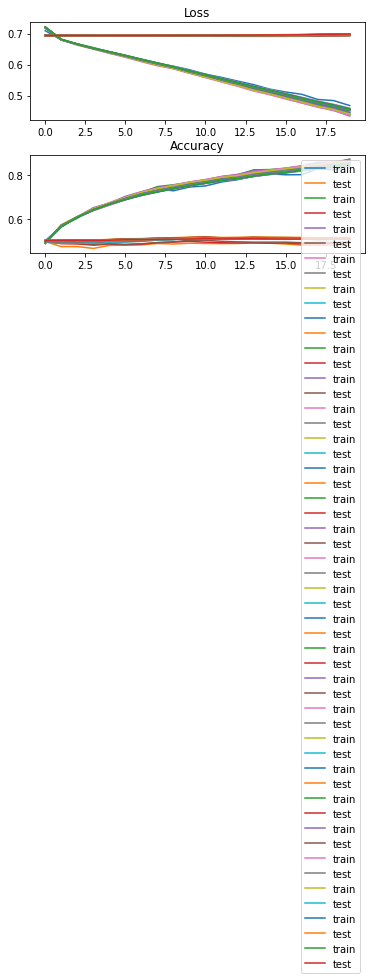

In [ ]:
#mo, me -> mi 정확도 추출 시 사용
from scipy.io import loadmat
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
#https://stackoverflow.com/questions/473973/shuffle-an-array-with-python-randomize-array-item-order-with-python

lst = ['S001','S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 
       'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 
       'S021', 'S022', 'S023', 'S024',  'S026', 'S027', 'S028'
       ]


c = 1           #fig save할 때 sub_num으로 사용하기 위한 변수 
sub_total = [] #한 피험자의 최종 평균 정확도 담는 배열 (피험자 순서대로 저장됨)
tmp = []

#피험자 별 loss, val_loss, acc, val_acc 값을 담기위한 list
loss_total = []
val_loss_total = []
acc_total = []
val_acc_total = []

#피험자 수만큼 돌아가는 반복문 
for i in range(len(lst)):       
  me_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_me_l.mat')
  me_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_me_r.mat')
  mo_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mo_l.mat')
  mo_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mo_r.mat')
  mi_l = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mi_l.mat')
  mi_r = loadmat('drive/MyDrive/data/'+lst[i]+'/epoched_mi_r.mat')

  me_l_tmp = me_l['epoched_me_l']
  me_r_tmp = me_r['epoched_me_r']
  mo_l_tmp = mo_l['epoched_mo_l']
  mo_r_tmp = mo_r['epoched_mo_r']
  mi_l_tmp = mi_l['epoched_mi_l']
  mi_r_tmp = mi_r['epoched_mi_r']

  me = np.concatenate([me_l_tmp, me_r_tmp], axis = 2)
  mo = np.concatenate([mo_l_tmp, mo_r_tmp], axis = 2)
  mi = np.concatenate([mi_l_tmp, mi_r_tmp], axis = 2)

  #-1, 0, 1, 2, 3 (총 4s 데이터)
  kernels, chans, samples = 1, 19, 1200

  me = torch.from_numpy(me)
  mi = torch.from_numpy(mi)
  mo = torch.from_numpy(mo)

  #(900, 19, 100) -> (100, 19, 900)
  me = me.permute(2, 1, 0)
  mi = mi.permute(2, 1, 0)
  mo = mo.permute(2, 1, 0)

  me = me.numpy()
  mi = mi.numpy()
  mo = mo.numpy()

  y = np.array([0] * 50 + [1] * 50)

  total_acc = []

  total_acc_me = []
  total_acc_mo = []
  total_acc_mi = []
  me_mo_x = np.concatenate([me, mo], axis = 0)
  me_mo_Y = np.concatenate([y, y], axis = 0)

  #10 - 3 fold 에서 10을 담당하는 반복문 
  #해당 코드는 5 fold로 train, test 데이터를 구분한 후, 10번 데이터를 셔플하는 순서로 진행됨 
  for j in range(10):
    me_mo_X, me_mo_y = shuffle(me_mo_x, me_mo_Y, random_state = 0)
    mi_X, mi_y = shuffle(mi, y, random_state = 0)

    # train : valid = 7:3 , test는 전체 데이터를 다 사용함 
    # ex) me->mi 예측 모델의 경우, me 100개를 7:3으로 train, valid 나누고 mi 전체를 test로 사용
    kfold = KFold(n_splits = 3) #7:3

    acc_result = []
    acc_result_me = []
    acc_result_mo = []
    acc_result_mi = []

    i += 1
    for train_idx, test_idx in kfold.split(me_mo_X, me_mo_y):

      me_mo_X_train_tmp, me_mo_X_test = me_mo_X[train_idx], me_mo_X[test_idx]
      me_mo_y_train_tmp, me_mo_y_test = me_mo_y[train_idx], me_mo_y[test_idx]
      me_mo_X_train, me_mo_X_valid, me_mo_y_train, me_mo_y_valid = train_test_split(me_mo_X_train_tmp, me_mo_y_train_tmp, test_size=0.4, shuffle=False)



      #각 값들 바꿔주면서 정확도 뽑으면 됨. 
      train_x = me_mo_X_train
      train_y = me_mo_y_train
      val_x = me_mo_X_valid
      val_y = me_mo_y_valid
      test_x = mi_X
      test_y = mi_y
      
      train_x = train_x.reshape(train_x.shape[0], chans, samples, kernels)
      val_x = val_x.reshape(val_x.shape[0], chans, samples, kernels)
      test_x = test_x.reshape(test_x.shape[0], chans, samples, kernels)

      
      with tf.device('/device:GPU:0'):
        model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
                dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')
        
        #loss func(sparse_categorical_crossentropy) 선택 이유 
        #https://ahnjg.tistory.com/88
        #https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics = ['accuracy'])

        fittedModel = model.fit(train_x, train_y, batch_size = 16, epochs = 20, 
                            verbose = 2,
                             validation_data=(val_x, val_y))
        # fittedModel_mo = model.fit(mo_X_train, mo_y_train, batch_size = 16, epochs = 10, 
        #                     verbose = 2, validation_data=(mo_X_valid, mo_y_valid))
        # fittedModel_mi = model.fit(mi_X_train, mi_y_train, batch_size = 16, epochs = 10, 
        #                     verbose = 2, validation_data=(mi_X_valid, mi_y_valid))
        
        loss_total.append(fittedModel.history['loss'])
        val_loss_total.append(fittedModel.history['val_loss'])
        acc_total.append(fittedModel.history['accuracy'])
        val_acc_total.append(fittedModel.history['val_accuracy'])

        probs       = model.predict(test_x)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == test_y.argmax(axis=-1))

        # probs_mo       = model.predict(mo_X_test)
        # preds_mo       = probs_mo.argmax(axis = -1)  
        # acc_mo         = np.mean(preds_mo == mo_y_test.argmax(axis=-1))

        # probs_mi       = model.predict(mi_X_test)
        # preds_mi       = probs_mi.argmax(axis = -1)  
        # acc_mi         = np.mean(preds_mi == mi_y_test.argmax(axis=-1))

      acc_result.append(acc)
      # acc_result_mo.append(acc_mo)
      # acc_result_mi.append(acc_mi)

    
    total_acc.append(np.mean(acc_result))
    # total_acc_mo.append(np.mean(acc_result_mo))
    # total_acc_mi.append(np.mean(acc_result_mi))
    
  tmp = [np.mean(total_acc)]
  sub_total.append(tmp) #한 피험자의 최종 정확도 저장 
  print("total acc =", tmp )

  #한 피험자 당 loss, acc 평균 내기 위한 부분
  m_loss = []
  m_val_loss = []
  m_acc = []
  m_val_acc = []
  s_loss = []
  s_val_loss = []
  s_acc = []
  s_val_acc = []
  for k in range(len(loss_total[0])): #epoch 갯수만큼 (현재는 epoch = 20)
    t1 = []
    t2 = []
    t3 = []
    t4 = []
    for j in range(len(loss_total)):
      t1.append(loss_total[j][k])
      t2.append(val_loss_total[j][k])
      t3.append(acc_total[j][k])
      t4.append(val_acc_total[j][k])
    m_loss.append(np.mean(t1))
    m_val_loss.append(np.mean(t2))
    m_acc.append(np.mean(t3))
    m_val_acc.append(np.mean(t4))
    
    s_loss.append(np.std(t1))
    s_val_loss.append(np.std(t2))
    s_acc.append(np.std(t3))
    s_val_acc.append(np.std(t4))
    
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.plot(m_loss, label='train')
  pyplot.plot(m_val_loss, label='test')

  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.plot(m_acc, label='train')
  pyplot.plot(m_val_acc, label='test')

  pyplot.legend()
  pyplot.subplots_adjust(left=0.125,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.2, 
                      hspace=0.35)
  
  # pyplot.savefig('%s.png'%c)
  c = c+1
  

sub_total #결과 정확도 출력

In [ ]:
sub_total #결과 정확도 출력

[[0.364],
 [0.5313333333333333],
 [0.633],
 [0.287],
 [0.502],
 [0.5403333333333334],
 [0.4103333333333333],
 [0.6046666666666667],
 [0.5053333333333334],
 [0.8963333333333334],
 [0.633],
 [0.4066666666666666],
 [0.41800000000000004],
 [0.3603333333333333],
 [0.5236666666666666],
 [0.5146666666666666],
 [0.47333333333333333],
 [0.5469999999999999],
 [0.38466666666666666],
 [0.471],
 [0.4090000000000001],
 [0.6746666666666667],
 [0.627],
 [0.3503333333333333],
 [0.5333333333333333],
 [0.5373333333333333],
 [0.5763333333333333]]